When training encoder-decoder models, an irritating deprecation warning is present, and I did not find a way to resolve it, other than downgrading to an older version of transformers.

In [1]:
! pip uninstall transformers --y && pip install transformers==4.45.2

Found existing installation: transformers 4.47.0
Uninstalling transformers-4.47.0:
  Successfully uninstalled transformers-4.47.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 76.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0


In [39]:
import pandas as pd
import numpy as np
import argparse
import os
import torch
import matplotlib.pyplot as plt
import langid
import langcodes
import json

from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, AutoModelForSeq2SeqLM,\
                         Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from typing import List
from peft import LoraConfig, get_peft_model, PeftConfig, PeftModel
from sklearn.metrics import f1_score, classification_report
from functools import partial
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from datasets import Dataset

plt.style.use("ggplot")
tqdm.pandas()

In [85]:
# You should configure your HuggingFace token as a notebook secret.
# https://www.kaggle.com/discussions/product-feedback/114053

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

# Global variables/parameters
HF_TOKEN = user_secrets.get_secret("hugging-face-access-token")
os.environ["HF_TOKEN"] = HF_TOKEN

SEED = 41
TRAIN_FRAC = 0.8
DATA_DIR = os.path.join("/", "kaggle", "input", "hate-speech-detection-curated-dataset")
DATASET_NAME = "HateSpeechDatasetBalanced.csv"
DATA_PATH = os.path.join(DATA_DIR, DATASET_NAME)
RESULTS_DIR = os.path.join("/", "kaggle", "working")

# Data preprocessing
For model training, we will use **HateSpeechDatasetBalanced**, which is the augmented variant of the original dataset, with practically equal class distribution which is very convenient. We will perform a simple 80/20 train/eval split, although this is configurable as well. When it comes to data transformation itself, we will not do any preprocessing, the augmented dataset is already preprocessed, albeit lowercased as well, and one hypothesis is that for sentiment classification casing plays an important role as well. However, we cannot revert a lowercased sentence reliably back to it's original non-lowercased form. 

In [86]:
def tt_split(dataset_path : str, q : float, output_dir : str, seed : int):
    df = pd.read_csv(dataset_path)
    df = df[["Content", "Label"]]
    # Some rows contain invalid values for Label column, disregard such rows
    df = df[df["Label"] != "Label"]
    y = df["Label"].to_numpy()

    # Preserve class distribution in obtained splits.
    X_train, X_test, _, _ = train_test_split(df, y, train_size = q, random_state = seed, stratify = y)

    train_label_dis = X_train["Label"].value_counts()
    test_label_dis = X_test["Label"].value_counts()

    train_dis_0 = train_label_dis.iloc[0]
    train_dis_1 = train_label_dis.iloc[1]
    train_total = train_dis_0 + train_dis_1

    test_dis_0 = test_label_dis.iloc[0]
    test_dis_1 = test_label_dis.iloc[1]
    test_total = test_dis_0 + test_dis_1

    print(f"0 train samples: {train_dis_0} 1 train samples: {train_dis_1} Total train samples: {train_total}")
    print(f"0 ratio: {(train_dis_0 / train_total):.4f} 1 ratio: {(train_dis_1 / train_total):.4f}")

    print(f"0 test samples: {test_dis_0} 1 test samples: {test_dis_1} Total test samples: {test_total}")
    print(f"0 ratio: {(test_dis_0 / test_total):.4f} 1 ratio: {(test_dis_1 / test_total):.4f}")

    # filename = os.path.basename(dataset_path).split(".")[0]
    # X_train.to_csv(os.path.join(output_dir, filename + "_train.csv"), index = False)
    # X_test.to_csv(os.path.join(output_dir, filename + "_test.csv"), index = False)

    return X_train, X_test

df_train, df_test = tt_split(DATA_PATH, TRAIN_FRAC, DATA_DIR, SEED)

0 train samples: 291620 1 train samples: 289275 Total train samples: 580895
0 ratio: 0.5020 1 ratio: 0.4980
0 test samples: 72905 1 test samples: 72319 Total test samples: 145224
0 ratio: 0.5020 1 ratio: 0.4980


## Visualizations
The augmented dataset is well-formatted, in a sense that for every sentence every word is seperated by a whitespace. This allows us to measure the word length distribution over the given dataset with. Additionally, during manual inspection, I noticed that there are multiple languages present in the given dataset, so I was considering using a multilingual model. However, it turns out that the number of non-English sentences is insignificant to the number of English sentences, and multilingual models are much more complex than monolingual models in terms of parameter complexity, so I decided to use a monolingual model. 

I used the `langid` Python library to detect the language of the given sentece, the classifier itself is not perfect but it helps us to get a rough idea about the underlying language distrubiton. It also produced some false negatives - English sentences classified as non-English sentences, I suspect that this might also be the effect of data augmentation, so in the end I did not discard any sentences, even if they were classified as non-English.

In [ ]:
'''
def identify_language(sentence : str):
    return langcodes.Language.get((langid.classify(sentence))[0]).display_name()

def sentence_word_length(sentence : str):
    return len(sentence.split(" "))

def word_length_distribution(dataset_path : str):
    df = pd.read_csv(dataset_path)
    print("Calculating sentence length over the given dataset.")
    df["WordLength"] = df["Content"].progress_apply(sentence_word_length)
    print("Done with sentence length calculation.")

    value_counts = df["WordLength"].value_counts().to_dict()
    lengths = []

    for key, value in value_counts.items():
        lengths = lengths + [key] * value

    print("Creating the sentence length distribution plot:")
    kde = gaussian_kde(lengths)
    fig, ax = plt.subplots()

    ax.set_xlabel("Comment length")
    ax.set_ylabel("Frequency")
    ax.set_title("Comment length distribution")

    x = np.linspace(min(lengths), max(lengths), 1000)
    bin_values = np.array(list(range(0, 301, 30)))
    ax.plot(x, kde(x), label = "Estimated PDF")
    ax.hist(lengths, alpha = 0.6, edgecolor = "black", density = True, bins = bin_values)
    ax.legend()
    ax.set_xticks(bin_values)
    plt.show()
    # fig_file = os.path.join(figures_dir, "sentence_length_distribution.png")
    # fig.savefig(fig_file, bbox_inches = "tight")
    # print("Sentence length distribution plot created and saved.")

def transform_language_counts(value_counts, threshold : float = 0.1):
    total = sum(v for v in value_counts.values())
    new_dict = {}

    for key, value in value_counts.items():
        if value >= int(total * threshold):
            new_dict[key] = value
        
        else:
            new_dict["Other"] = new_dict.get("Other", 0) + value
    
    return new_dict, total

def language_distribution(dataset_path : str, threshold : float = 0.1):
    df = pd.read_csv(dataset_path)
    print("Performing language classification over the given dataset:")
    df["Language"] = df["Content"].progress_apply(identify_language)
    print("Done with language classification.")
    
    value_counts = df["Language"].value_counts().to_dict()
    value_counts, total = transform_language_counts(value_counts, threshold)

    print("Creating the language distribution plot:")
    
    fig, ax = plt.subplots()
    bars = ax.barh(list(value_counts.keys()), value_counts.values(), edgecolor = "black")
    ax.set_xlabel("Language")
    ax.set_ylabel("Number of comments")
    ax.set_title("Language distribution")

    for bar in bars:
        width = bar.get_width()
        y_position = bar.get_y() + bar.get_height() / 2  # Positioning text vertically centered on the bar

        # Add number on top of the bar
        ax.text(width, y_position, f"{(width / total) * 100:.2f}%", ha = "left", va = "center", fontsize = 10, color = "black")

        # Draw a line from the label to the bar
        ax.plot([width, width + 0.2], [y_position, y_position], color = "black", linewidth = 0.7)
    plt.show()
    # plt.savefig(os.path.join(figures_dir, "language_distribution.png"), bbox_inches = "tight")

word_length_distribution(DATA_PATH)
language_distribution(DATA_PATH)
'''

# Fine-tunning an encoder model
For encoder models I've mostly experimented with RoBERTa encoders (https://huggingface.co/FacebookAI/roberta-base), but feel free to try different models. If you cannot afford long training times, I suggest taking a look at distilled variants, for RoBERTa - https://huggingface.co/distilbert/distilroberta-base. We will not fine-tune the fule model, instead just a LoRA, with a configurable rank parameter.

Because training times were very long, I did not perform any sophisticated hyperparameter optimization. One useful library of hyperparapeter optimization is optuna (https://optuna.org/), I've used it for some other projects of mine.

## Custom PyTorch Dataset class
We will implement a custom PyTorch Dataset class for our purposes. Additionally, we will use the F1 metric to evaluate our different models. Even though in my opinion ROC-AUC metric provides a more comprehensive way of comparing classification models because it incorporates different confidence thresholds, encoder-decoder models are non-probabilisitc, so we can only rely on macro-average F1 for them.

One possible optimization is to pre-tokenize the entire dataset, since tokenization is deterministic, and does not need to be repeated for every batch.

In [ ]:
# Combining a batch of sentences into an interpretable tenzor, leveraging the model's tokenization algorithm.
def collate_fn(batch : List[str], tokenizer : AutoTokenizer):
    comments = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch])

    res = tokenizer(
        comments,
        padding = True,
        truncation = True,
        return_tensors = "pt",
        return_attention_mask = True
    )
    
    res["labels"] = labels
    return res

class CommentClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, df, data_ratio = 1):
        self.df = df
        self.N = int(len(self.df) * data_ratio)
        self.df = self.df[:self.N]
        
    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        res = self.df.iloc[idx]
        return res["Content"], int(res["Label"])

def compute_f1(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis = -1)
    # This is equivalent to macro-averaged F1 since our dataset is well-balanced.
    f1 = f1_score(labels, preds, average = "weighted")

    return {
        "eval_f1": f1
    }

## Training

In [ ]:
'''
MODEL_URL = "roberta-base"
CLASSIFIER_DROPOUT = 0.1
LORA_DROPOUT = 0.1
LORA_ALPHA = 8
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-3
BATCH_SIZE = 8
GRAD_ACCUM = 1
LORA_RANK = 4
CHECKPOINT_DIR = os.path.join("/", "kaggle", "working", "encoder_checkpoints", "roberta_lora")
FROM_CHECKPOINT = False # Set to True if you want to continue training from a checkpoint, otherwise set to None. False maybe works even?
TRAIN_EPOCHS = 4
WARMUP_RATIO = 0.1
DATA_RATIO = 0.001 # Load only portion of the dataset for debugging, should be set to 1 once debugging is done.
DISABLE_TQDM = False # I've had issues with TQDM rendering inside a notebook

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
'''

In [ ]:
'''
id2label = {0: "Non-hateful", 1: "Hateful"}
label2id = {"Hateful": 1, "Non-hateful": 0}

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_URL,
    num_labels = 2,
    classifier_dropout = CLASSIFIER_DROPOUT,
    id2label = id2label,
    label2id = label2id,
    token = False
).to(DEVICE)

trainable_model_params = sum(p.numel() for p in model.parameters())
train_dataset = CommentClassificationDataset(df_train, data_ratio = DATA_RATIO)
test_dataset = CommentClassificationDataset(df_test, data_ratio = DATA_RATIO)
tokenizer = AutoTokenizer.from_pretrained(MODEL_URL)

lora_config = LoraConfig(
    r = LORA_RANK,
    lora_dropout = LORA_DROPOUT,
    bias = "none",
    lora_alpha = LORA_ALPHA,
    task_type = "SEQ_CLS",
    target_modules = ["query", "key", "value", "dense"], # By default only key and value linear maps lare lora-ed, this adds more expressivity
    # at the cost of model complexity.
    layers_to_transform = list(range(12)), # Apply loras on every layer of the base model, except the classification head.
    use_rslora = True
)

model = get_peft_model(model, lora_config)
lora_trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of model trainable parameters: {trainable_model_params}")
print(f"Number of LoRA trainable parameters: {lora_trainable_parameters}")
print(f"Conservation ratio: {trainable_model_params / lora_trainable_parameters:.4f}")

trainer_args = TrainingArguments(
    output_dir = CHECKPOINT_DIR,
    overwrite_output_dir = True,
    fp16 = False,
    report_to = "none",
    gradient_accumulation_steps = GRAD_ACCUM,
    per_device_train_batch_size = BATCH_SIZE,
    seed = SEED,
    data_seed = SEED,
    learning_rate = LEARNING_RATE,
    weight_decay = WEIGHT_DECAY,
    save_strategy = "epoch",
    eval_strategy = "epoch",
    logging_strategy = "epoch",
    num_train_epochs = TRAIN_EPOCHS,
    save_total_limit = 2,
    load_best_model_at_end = True,
    greater_is_better = True,
    metric_for_best_model = "eval_f1",
    lr_scheduler_type = "cosine",
    warmup_ratio = WARMUP_RATIO,
    disable_tqdm = DISABLE_TQDM,
    ddp_find_unused_parameters = False
)

trainer = Trainer(
    model = model,
    args = trainer_args,
    data_collator = partial(collate_fn, tokenizer = tokenizer),
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_f1
)

trainer.train(resume_from_checkpoint = FROM_CHECKPOINT)
'''

Best model will be loaded at the end, so you can perform inference immediately after training is finished. Alternatively, if you want to load a trained LoRA, you can use the template given below.

**Add segment where you put a URL to a model that you trained, and load it here and demonstrate that it works**.

In [ ]:
'''
checkpoint_path = os.path.join("/", "kaggle", "working", "encoder_checkpoints", "roberta_lora", "checkpoint-148")
lora_config = PeftConfig.from_pretrained(checkpoint_path)
id2label = {0: "Non-hateful", 1: "Hateful"}
label2id = {"Hateful": 1, "Non-hateful": 0}
base_model = AutoModelForSequenceClassification.from_pretrained(lora_config.base_model_name_or_path, id2label = id2label, label2id = label2id).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(lora_config.base_model_name_or_path)
model = PeftModel.from_pretrained(base_model, checkpoint_path).to(DEVICE) # Will use a single GPU for inference, but that is fine since no gradients are computed.
model.eval()

with torch.no_grad():
    sentences = ["Thank you very much.", "I hate you!"]
    enc = tokenizer(sentences, padding = True, truncation = True, return_tensors = "pt").to(DEVICE)
    res = model(**enc)

    logits = res.logits.cpu()
    probs = torch.nn.functional.softmax(logits, dim = -1)
    preds = torch.argmax(probs, dim = -1)
    counter = 0

    for pred, sentence in zip(preds, sentences):
        print(f"{sentence} Prediction: {model.config.id2label[int(pred.item())]} Probabilities: {probs[counter][0]:.4f} {probs[counter][1]:.4f}")
        counter += 1
'''

# Fine tunning an encoder-decoder model
Now we will try to utilize a full encoder-decoder architecture to see if we can improve previous results. One of the most popular encoder-decoder models is **T5 - Text to Text Transfer Transformer** (https://arxiv.org/pdf/1910.10683). On a high level, it transforms all NLP tasks into text2text problems, and then solves them using an encoder/decoder architecture. A high level overview of this paradigm can be seen of the figure below:

![no figure](https://miro.medium.com/v2/resize:fit:791/1*QOVXAn0bx8HKGrBIXAgydw.png)

We will take a pretrained T5 model, and fine-tune it for text classification. For this setting, our encoder will take the sentence in question, and the decoder will be fine-tuned to autoregressively predict the correct class. Class labels that we choose are also hyperparameters, but I do not think they can effect results that much if the model is trained for sufficiently long, provided that they are semantically consistent with actual labels of course.
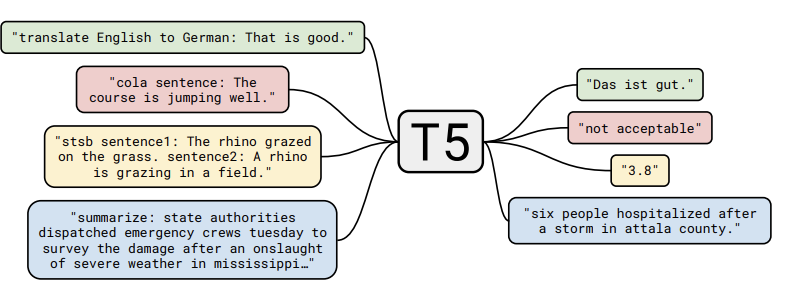

In [105]:
MODEL_URL = "google/flan-t5-base"
CLASSIFIER_DROPOUT = 0.1
LORA_DROPOUT = 0.1
LORA_ALPHA = 18
LEARNING_RATE = 3e-4 # Authors of FLAN T5 use higher learning rate compared to that of RoBERTa, we will adhere to that.
WEIGHT_DECAY = 1e-3
BATCH_SIZE = 8
GRAD_ACCUM = 1
LORA_RANK = 18
CHECKPOINT_DIR = os.path.join("/", "kaggle", "working", "encoder_decoder_checkpoints", "flan_t5_small_test")
FROM_CHECKPOINT = False # Set to True if you want to continue training from a checkpoint, otherwise set to None. False maybe works even?
TRAIN_EPOCHS = 2
WARMUP_RATIO = 0.1
DATA_RATIO = 1 # Load only portion of the dataset for debugging, should be set to 1 once debugging is done.
DISABLE_TQDM = False # I've had issues with TQDM rendering inside a notebook
HATE_LABEL = "Hateful"
NON_HATE_LABEL = "Non-hateful"

LABEL2TEXT = {
    0: NON_HATE_LABEL,
    1: HATE_LABEL
}

TEXT2LABEL = {
    v: k for k, v in LABEL2TEXT.items()
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PREFIX = f"Classify this sentence as {HATE_LABEL} or {NON_HATE_LABEL} speech:"

## Encoder-decoder dataset class
Pre-processing for encoder-decoder models is more complex - target sequences need to be shifted accordingly. Instead of using PyTorch Dataset, we will use HuggingFace Dataset API, along with DataCollatorForSeq2Seq. With these 2 classes, we will delegate the entire tokenization procedure to HuggingFace. Additionally, HuggingFace Dataset will allow us to easily pre-tokenize the entire dataset, which was an issue with previous encoder approach.

In [103]:
def tokenize_function(batch, tokenizer, prefix = ""):
    # model maximum length is encoded in the pre-trained tokenizer.
    content = [f"{prefix} {x}".strip() for x in batch["Content"]]
    inputs = tokenizer(content, truncation = True, padding = False)
    targets = tokenizer(text_target = [LABEL2TEXT[int(x)] for x in batch["Label"]], truncation = True, padding = False)
    inputs["labels"] = targets["input_ids"]
    return inputs
    
tokenizer = AutoTokenizer.from_pretrained(MODEL_URL, legacy = False)
# https://huggingface.co/docs/datasets/v3.5.0/en/package_reference/main_classes#datasets.Dataset.from_pandas
# https://huggingface.co/docs/datasets/v3.5.0/en/package_reference/main_classes#datasets.Dataset.map
train_dataset = Dataset.from_pandas(df_train[:int(len(df_train) * DATA_RATIO)])
train_dataset = train_dataset.map(partial(tokenize_function, tokenizer = tokenizer, prefix = PREFIX), 
                                  batched = True, 
                                  remove_columns = train_dataset.column_names,
                                  desc = "Tokenizing the train dataset.",
                                  keep_in_memory = True
                                  # cache_file_name = os.path.join("/", "kaggle", "working", "train_seq2seq.cache"),
                                  # load_from_cache_file = True
                                 )

test_dataset = Dataset.from_pandas(df_test[:int(len(df_test) * DATA_RATIO)])
test_dataset = test_dataset.map(partial(tokenize_function, tokenizer = tokenizer, prefix = PREFIX), 
                                  batched = True, 
                                  remove_columns = test_dataset.column_names,
                                  desc = "Tokenizing the test dataset.",
                                  keep_in_memory = True
                                  # cache_file_name = os.path.join("/", "kaggle", "working", "test_seq2seq.cache"),
                                  # load_from_cache_file = True
                                )

target_encodings = tokenizer(text_target = [v for v in LABEL2TEXT.values()], padding = True, return_tensors = "pt")
MAX_TARGET_LEN = target_encodings["input_ids"].shape[1]

PAD_ID = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

def compute_f1_seq2seq(pred, tokenizer):
    predictions = pred.predictions
    labels = pred.label_ids
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens = True)
    # Labels are -100 for pad tokens, so replace them with actual pad id.
    # https://huggingface.co/docs/transformers/en/model_doc/t5?usage=AutoModel#transformers.T5ForConditionalGeneration.forward.labels
    labels[labels == -100] = PAD_ID
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens = True)

    decoded_labels = [TEXT2LABEL[item] for item in decoded_labels]
    decoded_preds = [TEXT2LABEL.get(item.strip(), -1) for item in decoded_preds]

    # Class -1 captures the case when model output does not match to any of the classes, we create a new class for that instance.
    # Since decoded_preds != -1 always, the number of instances having class -1 is always 0, so we explicitly set zero_divison = 0
    # so that our final result is not affected by this.
    f1 = f1_score(decoded_preds, decoded_labels, labels = [0, 1, -1], average = "weighted", zero_division = 0)
    
    return {
        "eval_f1": f1
    }

Tokenizing the train dataset.:   0%|          | 0/580895 [00:00<?, ? examples/s]

Tokenizing the test dataset.:   0%|          | 0/145224 [00:00<?, ? examples/s]

## Optional base model evaluation
Optionally, you can evaluate the performance of a baseline T5 model. A model like FLAN-T5 which we will be using which was fine-tuned already should give reasonable results - I would expect above 0.6 F1. We will perform another iteration of fine-tuning over our dataset to further push the performance.

In [98]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_URL).to(DEVICE)
predictions, ground_truth = [], []

with torch.no_grad():
    print(f"Baseline model evaluation: {MODEL_URL}")
    batch_size = 128
    
    for i in tqdm_notebook(range(0, len(test_dataset), batch_size)):
        batch = test_dataset[i : i + batch_size]
        # Manual padding because of dataset construction required.
        batch = tokenizer.pad(batch, padding = "longest")
        input_ids = torch.tensor(batch["input_ids"], device = DEVICE)
        labels = tokenizer.batch_decode(batch["labels"], skip_special_tokens = True)
        
        output = model.generate(inputs = input_ids, max_new_tokens = MAX_TARGET_LEN)
        output = tokenizer.batch_decode(output, skip_special_tokens = True)
        output = [item.strip() for item in output]

        ground_truth += [TEXT2LABEL[item] for item in labels]
        predictions += [TEXT2LABEL.get(item, -1) for item in output]

# If the model is well-behaved, nothing will be generated outside Hateful and Non-hateful,  
cls_rprt = classification_report(predictions, ground_truth, labels = [0, 1, -1], zero_division = 0)
print(f"Baseline classification report:")
print(cls_rprt)
baseline_f1 = f1_score(predictions, ground_truth, labels = [0, 1], average = "weighted", zero_division = 0)
print(f"Baseline F1:")
print(baseline_f1)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Baseline model evaluation: google/flan-t5-base


  0%|          | 0/23 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Baseline classification report:
              precision    recall  f1-score   support

           0       0.78      0.63      0.70      1771
           1       0.55      0.72      0.62      1132
          -1       0.00      0.00      0.00         1

    accuracy                           0.66      2904
   macro avg       0.44      0.45      0.44      2904
weighted avg       0.69      0.66      0.67      2904

Baseline F1:
0.6691414844620971


## Training an encoder-decoder model

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_URL).to(DEVICE)
# generate calls will default to greedy decoding. The decoding algorithm can be viewed as a hyperparameter also!
# https://huggingface.co/docs/transformers/v4.51.0/en/main_classes/text_generation#transformers.GenerationConfig
print(f"Model generation config: {model.generation_config}")

lora_config = LoraConfig(
    r = LORA_RANK,
    lora_dropout = LORA_DROPOUT,
    bias = "none",
    lora_alpha = LORA_ALPHA,
    task_type = "SEQ_2_SEQ_LM",
    # at the cost of model complexity.
    layers_to_transform = list(range(12)), # Apply loras on every layer of the base model, except the classification head.
    use_rslora = True
)

trainable_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model = get_peft_model(model, lora_config)

# Autoregressive generation is significantlly slower than a simple forward pass through the model
# which explains why training is slower as well on a T5 model.
#import time
#x = train_dataset[:16]
#x["input_ids"] = torch.tensor(x["input_ids"]).to(DEVICE)
#x["attention_mask"] = torch.tensor(x["attention_mask"]).to(DEVICE)
#x["labels"] = torch.tensor(x["labels"]).to(DEVICE)
#start = time.time()
#y = model.generate(**x, max_length = MAX_TARGET_LEN)
# y = model(**x)
#end = time.time()
#print(f"Generation time: {end - start}:.4f seconds.")
#print(y)
#return

lora_trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

# 124647170 - Number of RoBERTa-base parameters
# 247577856 - Number of T5 base parameters. Roughly 2 times higher than RoBERTa, which is expected.
print(f"Number of model trainable parameters: {trainable_model_params}")
print(f"Number of LoRA trainable parameters: {lora_trainable_parameters}")
print(f"Conservation ratio: {trainable_model_params / lora_trainable_parameters:.4f}")

collator = DataCollatorForSeq2Seq(tokenizer = tokenizer, model = model, padding = "longest")

# Control predict_with_generate behaviour:
# https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Seq2SeqTrainingArguments.predict_with_generate
# https://huggingface.co/docs/transformers/v4.51.0/en/main_classes/text_generation#transformers.GenerationConfig
# https://huggingface.co/docs/transformers/en/main_classes/text_generation#transformers.GenerationMixin.generate
training_args = Seq2SeqTrainingArguments(
    output_dir = CHECKPOINT_DIR,
    overwrite_output_dir = True,
    fp16 = False,
    report_to = "none",
    gradient_accumulation_steps = GRAD_ACCUM,
    per_device_train_batch_size = BATCH_SIZE,
    seed = SEED,
    data_seed = SEED,
    learning_rate = LEARNING_RATE,
    weight_decay = WEIGHT_DECAY,
    save_strategy = "epoch",
    eval_strategy = "epoch",
    logging_strategy = "epoch",
    num_train_epochs = TRAIN_EPOCHS,
    save_total_limit = 2,
    load_best_model_at_end = True,
    greater_is_better = True,
    metric_for_best_model = "eval_f1",
    lr_scheduler_type = "cosine",
    warmup_ratio = WARMUP_RATIO,
    disable_tqdm = DISABLE_TQDM,
    ddp_find_unused_parameters = False,
    predict_with_generate = True,
    generation_config = MODEL_URL,
    generation_max_length = MAX_TARGET_LEN # Attempt to optimize generation a little bit...
)

# Can't solve Trainer.tokenizer is deprecated warning...
# https://github.com/hiyouga/LLaMA-Factory/issues/6130
trainer = Seq2SeqTrainer(
    model = model,
    args = training_args,
    data_collator = collator,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = partial(compute_f1_seq2seq, tokenizer = tokenizer)
)
trainer.train(resume_from_checkpoint = FROM_CHECKPOINT)